Leyendo datos desde: sent_train_clean_dedup.csv
Total de registros válidos: 9419

Ejemplo de datos (crudos):
                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3                $ESS: BTIG Research cuts to Neutral      0
4    $FNKO - Funko slides after Piper Jaffray PT cut      0

Ejemplo tras normalización y tokenización avanzada:
------------------------------------------------------------
Texto original:  $BYND - JPMorgan reels in expectations on Beyond Meat
Texto normalizado: $BYND - JPMorgan reels in expectations on Beyond Meat
Tokens: ['$bynd', 'jpmorgan', 'reels', 'in', 'expectations', 'on', 'beyond', 'meat']
------------------------------------------------------------
Texto original:  $CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean
Texto normalizado: $CCL $RCL - 

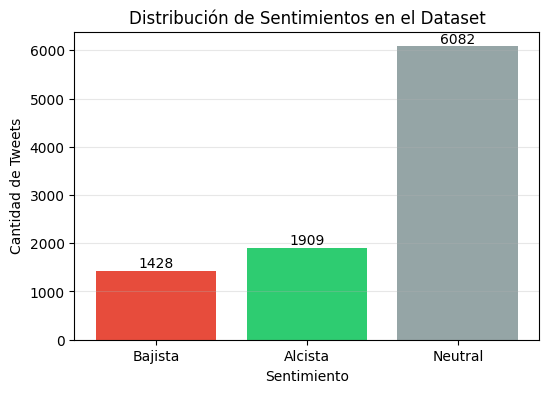

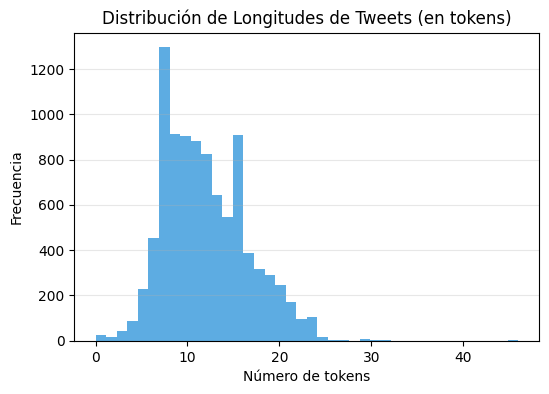


Estadísticas de longitud de tokens:
count    9419.000000
mean       11.990551
std         4.483117
min         0.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        46.000000
Name: len_tokens, dtype: float64

División realizada:
 - Train: 6593 (70.0%)
 - Val:   1412 (15.0%)
 - Test:  1414 (15.0%)

Construyendo vocabulario avanzado (solo con TRAIN)...
Tamaño final del vocabulario: 5605 tokens

¡Proceso completado! Archivos guardados en la carpeta 'data_processed/'
 - train.csv, val.csv, test.csv
 - vocab.pkl


In [2]:
# =============================================================================
# NOTEBOOK 1: PREPARACIÓN DE DATOS Y VOCABULARIO (VERSIÓN AVANZADA)
# =============================================================================

import pandas as pd
import numpy as np
import random
import pickle
import os
import re
from collections import Counter
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
SEED = 42
DATA_PATH = "sent_train_clean_dedup.csv"  # Archivo original ya limpiado a nivel básico
OUTPUT_DIR = "data_processed"

# Crear carpeta de salida si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Fijar semillas para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)

print(f"Leyendo datos desde: {DATA_PATH}")

# -----------------------------------------------------------------------------
# 1. CARGA Y LIMPIEZA INICIAL
# -----------------------------------------------------------------------------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró el archivo {DATA_PATH}. Por favor súbelo.")

df = pd.read_csv(DATA_PATH)

# Eliminar filas vacías
df = df.dropna(subset=["text", "label"]).reset_index(drop=True)

# Asegurar tipos de datos
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

print(f"Total de registros válidos: {len(df)}")
print("\nEjemplo de datos (crudos):")
print(df.head())

# -----------------------------------------------------------------------------
# 2. PREPROCESAMIENTO AVANZADO DE TEXTO
# -----------------------------------------------------------------------------
URL_PATTERN = re.compile(r"http\S+|www\.\S+")
USER_PATTERN = re.compile(r"@\w+")
NUMBER_PATTERN = re.compile(r"\d+(\.\d+)?")

def normalize_text(text: str) -> str:
    """
    Normalización avanzada:
    - Mantiene jerga financiera (tickers $TSLA, hashtags, etc.).
    - Reemplaza URLs por <URL>.
    - Reemplaza menciones por <USER>.
    - Reemplaza números por <NUM>.
    - Colapsa puntuación repetida.
    - Limpia espacios extra.
    """
    text = str(text)

    # URLs -> <URL>
    text = URL_PATTERN.sub(" <URL> ", text)

    # Usuarios -> <USER>
    text = USER_PATTERN.sub(" <USER> ", text)

    # Números -> <NUM>
    text = NUMBER_PATTERN.sub(" <NUM> ", text)

    # Colapsar puntuación repetida !!!???...
    text = re.sub(r"([!?.,])\1+", r"\1", text)

    # Espacios múltiples -> 1 espacio
    text = re.sub(r"\s+", " ", text).strip()

    return text

def advanced_tokenize(text: str):
    """
    Tokenizador avanzado:
    - Convierte a minúsculas.
    - Conserva tickers tipo $tsla, $btc.
    - Conserva hashtags: #crypto, #stocks.
    - Conserva tokens especiales: <url>, <user>, <num>.
    - Extrae palabras alfabéticas y signos de exclamación/pregunta.
    """
    text = text.lower()
    # Regex:
    # \$[a-z]+          -> tickers ($tsla)
    # #[a-z0-9_]+       -> hashtags
    # <url>|<user>|<num> -> tokens especiales
    # [a-z]+            -> palabras
    # [!?]              -> signos de énfasis
    pattern = r"\$[a-z]+|#[a-z0-9_]+|<url>|<user>|<num>|[a-z]+|[!?]"
    tokens = re.findall(pattern, text)
    return tokens

# Aplicar normalización
df["text_norm"] = df["text"].apply(normalize_text)

# Crear columna de tokens avanzados
df["tokens"] = df["text_norm"].apply(advanced_tokenize)

# Longitud de cada tweet (en tokens)
df["len_tokens"] = df["tokens"].apply(len)

print("\nEjemplo tras normalización y tokenización avanzada:")
for i in range(5):
    print("-" * 60)
    print("Texto original: ", df.loc[i, "text"])
    print("Texto normalizado:", df.loc[i, "text_norm"])
    print("Tokens:", df.loc[i, "tokens"])

# -----------------------------------------------------------------------------
# 3. ANÁLISIS EXPLORATORIO (EDA)
# -----------------------------------------------------------------------------
conteo_clases = df["label"].value_counts().sort_index()
labels_map = {0: "Bajista", 1: "Alcista", 2: "Neutral"}

plt.figure(figsize=(6, 4))
bars = plt.bar(conteo_clases.index, conteo_clases.values,
               color=["#e74c3c", "#2ecc71", "#95a5a6"])
plt.xticks([0, 1, 2], [labels_map[0], labels_map[1], labels_map[2]])
plt.title("Distribución de Sentimientos en el Dataset")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de Tweets")
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f"{int(height)}", ha="center", va="bottom")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(df["len_tokens"], bins=40, color="#3498db", alpha=0.8)
plt.title("Distribución de Longitudes de Tweets (en tokens)")
plt.xlabel("Número de tokens")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)
plt.show()

print("\nEstadísticas de longitud de tokens:")
print(df["len_tokens"].describe())

# -----------------------------------------------------------------------------
# 4. DIVISIÓN DE DATOS (TRAIN / VAL / TEST)
# -----------------------------------------------------------------------------
# Mezclamos el dataset
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

n_total = len(df)
n_train = int(0.70 * n_total)
n_val = int(0.15 * n_total)

train_df = df.iloc[:n_train].copy()
val_df = df.iloc[n_train:n_train + n_val].copy()
test_df = df.iloc[n_train + n_val:].copy()

print(f"\nDivisión realizada:")
print(f" - Train: {len(train_df)} ({len(train_df)/n_total:.1%})")
print(f" - Val:   {len(val_df)} ({len(val_df)/n_total:.1%})")
print(f" - Test:  {len(test_df)} ({len(test_df)/n_total:.1%})")

# Para el resto del pipeline (Notebooks 2 y 3) usaremos la columna 'text_norm'
# como texto principal, renombrándola simplemente a 'text' para mantener
# compatibilidad con el código ya escrito.
train_df["text"] = train_df["text_norm"]
val_df["text"] = val_df["text_norm"]
test_df["text"] = test_df["text_norm"]

# -----------------------------------------------------------------------------
# 5. CREACIÓN DEL VOCABULARIO (USANDO SOLO TRAIN)
# -----------------------------------------------------------------------------
def build_vocab(token_lists, min_freq=2):
    counter = Counter()
    for toks in token_lists:
        counter.update(toks)

    vocab = {"<PAD>": 0, "<UNK>": 1}
    idx = 2
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

print("\nConstruyendo vocabulario avanzado (solo con TRAIN)...")
vocab = build_vocab(train_df["tokens"].tolist(), min_freq=2)
print(f"Tamaño final del vocabulario: {len(vocab)} tokens")

# -----------------------------------------------------------------------------
# 6. GUARDADO DE ARTEFACTOS
# -----------------------------------------------------------------------------
# Guardamos solo columnas necesarias para el entrenamiento posterior
cols_to_save = ["text", "label"]

train_df[cols_to_save].to_csv(f"{OUTPUT_DIR}/train.csv", index=False)
val_df[cols_to_save].to_csv(f"{OUTPUT_DIR}/val.csv", index=False)
test_df[cols_to_save].to_csv(f"{OUTPUT_DIR}/test.csv", index=False)

with open(f"{OUTPUT_DIR}/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

print(f"\n¡Proceso completado! Archivos guardados en la carpeta '{OUTPUT_DIR}/'")
print(" - train.csv, val.csv, test.csv")
print(" - vocab.pkl")
